In [ ]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from common import load_crs, load_stops
from determine_stop_polygons import (
    determine_concave_area,
    determine_stop_geometries_from_walk,
)

In [2]:
CITY = "budapest"
VERSION = "20250401"
ELLIPTICITY_THRESHOLD = 5
CONCAVENESS = 0.2

In [3]:
crs = load_crs()

with open(f"../data/stops/{CITY}/{VERSION}/accessible_stops.json", "r") as fp:
    accessible_stops = json.load(fp)

# all_stops = set([i for k, v in accessible_stops.items() for i in v])
# len(all_stops)

isochrones = pd.read_csv(
    f"../output/{CITY}/{VERSION}/isochrones.csv",
    dtype={"stop_id": str},
)
isochrones["geometry"] = isochrones["geometry"].apply(shapely.from_wkt)
isochrones = gpd.GeoDataFrame(isochrones, geometry="geometry", crs=4326)

stops = load_stops(CITY, VERSION)

In [4]:
cc_area = determine_concave_area(
    stops,
    accessible_stops,
    crs=crs[CITY],
    concaveness_ratio=CONCAVENESS,
)

2
LINESTRING (641991.1468592602 203505.07875317338, 642322.5227472831 209320.81617872068)
3
POLYGON ((643100.1903284915 214023.06125842966, 641991.1468592602 203505.07875317338, 642322.5227472831 209320.81617872068, 643100.1903284915 214023.06125842966))
6
POLYGON ((643100.1903284915 214023.06125842966, 644464.3376397184 218820.91372478334, 643128.6277753444 214076.05544399403, 644194.5781860158 213432.11788522222, 642322.5227472831 209320.81617872068, 644170.5622708425 213405.01660746065, 643100.1903284915 214023.06125842966))
8
POLYGON ((644455.5268561487 218857.7194545446, 645168.0543566932 219705.86888979026, 644464.3376397184 218820.91372478334, 643128.6277753444 214076.05544399403, 644194.5781860158 213432.11788522222, 642322.5227472831 209320.81617872068, 644170.5622708425 213405.01660746065, 643100.1903284915 214023.06125842966, 644455.5268561487 218857.7194545446))
74
POLYGON ((649970.2030508607 236690.41706866134, 649949.1741624711 236744.44840028053, 650431.124256658 236829.

In [4]:
sgfw = determine_stop_geometries_from_walk(
    stops,
    isochrones.query("costing == 'walk' & range == 5"),
    accessible_stops,
    crs=crs[CITY],
    ellipticity_threshold=ELLIPTICITY_THRESHOLD,
)
cc_area = determine_concave_area(
    stops,
    accessible_stops,
    crs=crs[CITY],
    concaveness_ratio=CONCAVENESS,
)
sgfw = sgfw.merge(cc_area, on="stop_id")

sgfw.to_csv(f"../output/{CITY}/{VERSION}/stop_geometries_from_walk.csv", index=False)
sgfw.to_file(f"../output/{CITY}/{VERSION}/stop_geometries_from_walk.geojson")

In [5]:
sgfw

stop_id                                           geometry   area  \
0       044369  MULTIPOLYGON (((18.94258 47.1766, 18.94336 47....  0.359   
1     CSF04632  MULTIPOLYGON (((18.94258 47.1766, 18.94336 47....  0.543   
2       009749  MULTIPOLYGON (((18.94897 47.22702, 18.9488 47....  0.994   
3     CSF04627  MULTIPOLYGON (((18.9488 47.22592, 18.94707 47....  1.435   
4       008155  MULTIPOLYGON (((19.07074 47.44585, 19.07205 47...  8.180   
...        ...                                                ...    ...   
4943    F00966  POLYGON ((19.04976 47.48739, 19.04821 47.48746...  5.490   
4944    F00967  POLYGON ((19.05823 47.48437, 19.05736 47.48473...  6.585   
4945    F00924  POLYGON ((19.05073 47.48681, 19.05034 47.48678...  5.913   
4946    F00982  MULTIPOLYGON (((19.03998 47.49647, 19.03882 47...  2.523   
4947    F00102  MULTIPOLYGON (((19.03149 47.48679, 19.03145 47...  3.626   

      ellipticity  number_of_accessible_stops  concave_area  
0             NaN                           2         0.000  
1             NaN                           3         1.482  
2          0.7500                           6         0.115  
3          0.8157                           8         0.178  
4          0.4820                          74         4.650  
...           ...                         ...           ...  
4943       0.4227                          55         2.979  
4944       0.5911                          69         1.773  
4945       0.5786                          64         1.965  
4946       0.2850                          28         0.439  
4947       0.5933                          34         1.343  

[4948 rows x 6 columns]

Text(0.5, 1.0, 'correlation coefficient: 0.8491 | budapest')

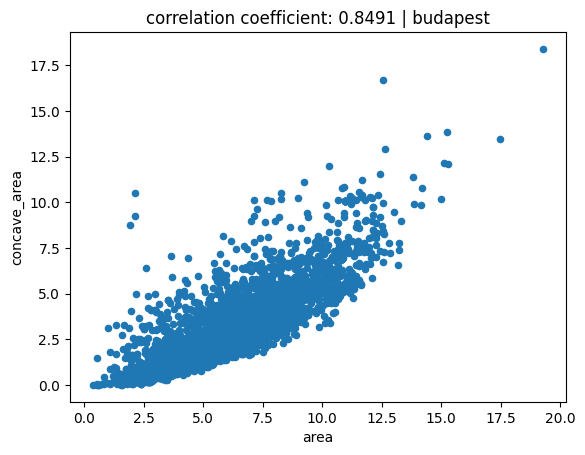

In [14]:
r = sgfw["area"].corr(sgfw["concave_area"])
fig, ax = plt.subplots()
sgfw.plot.scatter(x="area", y="concave_area", ax=ax)
ax.set_title(f"correlation coefficient: {r:0.04f} | {CITY}")

In [43]:
# stop = "009461"
# # stop = "009749"
# fig, ax = plt.subplots()
# sgfw[sgfw["stop_id"] == stop].plot(ax=ax, fc="#afdfff", ec="#00aaff")
# stops[
#     (stops["stop_id"].isin(accessible_stops[stop])) & (stops["stop_id"] != stop)
# ].plot(ax=ax, color="#2d2d2d", markersize=15, zorder=5)
# stops[stops["stop_id"] == stop].plot(ax=ax, color="red", markersize=20, zorder=10)